Run the cell to set up the linear wind model as a function that can be called with an elevation map:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv

def MSJH(z):
    """
    Linear model for turbulent flow over low hills derived
    from Jackson and Hunt (1975), Mason and Sykes (1979)
    """    
    np.seterr(all='ignore')
    # Iteration to find the inner region thickness l (m)
    l = (z0/8)*(L0/z0)**0.9
    for i in range(10):
        l = 2*0.16*L0/np.log(l/z0)
    a = (np.log(L0/z0))**2/(np.log(l/z0)*np.log(zu/z0))
    # Fourier transform
    Fz = fft2(z)
    Fz = fftshift(Fz)
    # Wavenumbers and modified Bessel functions
    n = z.shape[0]
    k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
    m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
    bu = 1 - kv(0,2*np.sqrt(1j*L0*k*zu/l))/kv(0,2*np.sqrt(1j*L0*k*z0/l))
    bv = 1 - kv(0,2*np.sqrt(2*1j*L0*k*zu/l))/kv(0,2*np.sqrt(2*1j*L0*k*z0/l))
    bu[n//2] = 0
    bv[n//2] = 0
    # Fourier components of u and v
    Fu = np.zeros_like(Fz)
    Fv = np.zeros_like(Fz)
    for i in range(n):
        for j in range(n):
            r = np.sqrt(k[j]**2 + m[i]**2)
            if r>0:
                Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
                Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]
    # Inverse Fourier transform
    Fu = ifftshift(Fu)
    Fv = ifftshift(Fv)
    u = 1 + np.real(ifft2(Fu))
    v = np.real(ifft2(Fv))
    return u,v

def wind_model(z,dir):
    """
    Superposition of wind simulations for cardinal directions

    Arguments:
    z - array of elevations
    dir - wind direction in degrees, clockwise from north

    Returns:
    u - east-west component of wind vector
    v - south-north component of wind vector
    wind - wind speed
    """
    # westerly wind
    uW,vW = MSJH(z)
    # southerly wind
    zr = np.flipud(z.T)
    u,v = MSJH(zr)
    uS = - np.fliplr(v.T)
    vS = np.fliplr(u.T)
    # easterly wind
    zr = np.flipud(np.fliplr(z))
    u,v = MSJH(zr)
    uE = - np.flipud(np.fliplr(u))
    vE = - np.flipud(np.fliplr(v))
    # Northerly wind
    zr = np.fliplr(z.T)
    u,v = MSJH(zr)
    uN = np.flipud(v.T)
    vN = - np.flipud(u.T)
    
    # combine simulations according to quadrant
    theta = np.deg2rad(dir)
    if dir<90:     # NE
        u = np.sin(theta)*uE + np.cos(theta)*uN
        v = np.sin(theta)*vE + np.cos(theta)*vN
    elif dir<180:  # SE
        u = np.sin(theta)*uE - np.cos(theta)*uS
        v = np.sin(theta)*vE - np.cos(theta)*vS
    elif dir<270:  # SW
        u = - np.sin(theta)*uW - np.cos(theta)*uS
        v = - np.sin(theta)*vW - np.cos(theta)*vS
    else:                # NW
        u = - np.sin(theta)*uW + np.cos(theta)*uN
        v = - np.sin(theta)*vW + np.cos(theta)*vN
    
    wind = np.sqrt(u**2 + v**2)
    return u,v,wind

In [3]:
# Parameters
topo_file = 'hill.txt'       # Elevation file name
dir = 225                    # Wind direction (degrees)
dx = 10.                     # Grid spacing (m)
L0 = 1000.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 1.5                     # Wind measurement height (m)

The next cell reads a digital terrain model from a `.tif` file. A [Tukey window](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.tukey.html) is used to smooth the real topography to fit the periodic boundary condtions of the linear model.

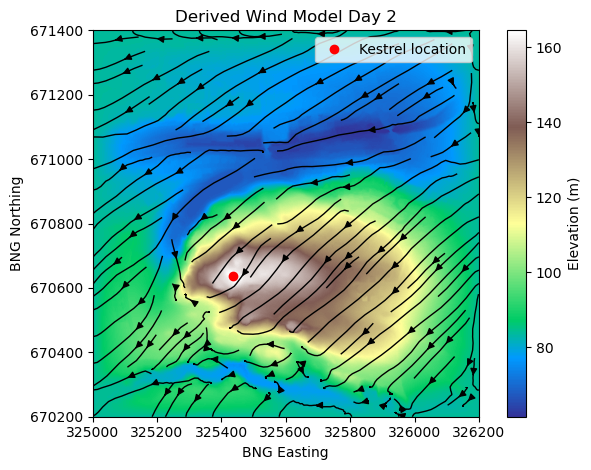

In [ ]:
from osgeo import gdal
from scipy.signal.windows import tukey

# grid coordinates and elevation from DTM
gdal.UseExceptions()
ds = gdal.Open('Blackford_2M_DTM_PHASE5.tif')
xul, dx, _, yul, _, dy = ds.GetGeoTransform()
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
z = z[::-1,:]
ny, nx = z.shape
x = xul + np.arange(nx)*dx
y = yul - (ny - np.arange(ny))*dx

# Get georeferencing information
x_max = xul + (ds.RasterXSize * dx)
y_min = yul + (ds.RasterYSize * dy)
# Create grid coordinates
x = np.linspace(xul, x_max, ds.RasterXSize)
y = np.linspace(y_min, yul, ds.RasterYSize)
X, Y = np.meshgrid(x, y)

u,v,wind = wind_model(z,dir)
u2,v2,wind2 = wind_model(z,54.6) # Vary for wind direction required

# smoothed topography for periodic boundary conditions
zm = np.mean([z[:,0],z[-1,:],z[:,-1],z[0,:]])
window = np.sqrt(np.outer(tukey(nx),tukey(ny))) 
zsmooth = (z - zm)*window + zm

# Plot original and smoothed topography
cmap = 'terrain'

# Original topography
im = plt.imshow(zsmooth, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap)
plt.streamplot(X, Y, u2, v2, color="k", linewidth=1, density=1)
plt.title('Derived Wind Model Day 2')
plt.xlabel('BNG Easting')
plt.ylabel('BNG Northing')
plt.colorbar(im, label='Elevation (m)')

x = 25437+300000
y = 70637+600000

plt.plot(x, y, 'ro', label = 'Kestrel location')
plt.legend()

plt.tight_layout()
plt.savefig('linearmodel2.png')
plt.show()